## MLP (Multi-Layer Perceptron) Approach
- I will implement the Language Model using the Multi-Layer Perceptron (MLP)-based method described in Bengio’s research paper.  
- The core idea is to learn distributed word representations (embeddings) instead of using simple one-hot encodings.  
- Each word is mapped to a continuous vector, and the model predicts the probability of the next word given the previous ones.  
- This is achieved by feeding the embeddings of context words into a Multi-Layer Perceptron, which learns both the word embeddings and the probability distribution simultaneously.  
- This approach marked one of the first successful attempts at using neural networks for statistical language modeling, paving the way for modern architectures like RNNs and Transformers.  

**References:**  
- Bengio, Y., Ducharme, R., Vincent, P., & Jauvin, C. (2003). *A Neural Probabilistic Language Model*. Journal of Machine Learning Research, 3, 1137–1155. Retrieved from [https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)  
- Karpathy, A. (2022). *The makemore series*. Retrieved from [https://karpathy.ai](https://karpathy.ai)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', mode = 'r', encoding='utf-8').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}

In [4]:
x, y = [], []
block_size = 3
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        idx = stoi[ch]
        x.append(context)
        y.append(idx)
        # print(f"{''.join([itos[i] for i in context])} --> {itos[idx]}")
        context = context[1:] + [idx]
x, y = torch.tensor(x), torch.tensor(y)

In [5]:
def generate_dataset(words):
    x, y = [], []
    block_size = 3
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            x.append(context)
            y.append(idx)
            # print(f"{''.join([itos[i] for i in context])} --> {itos[idx]}")
            context = context[1:] + [idx]
    x, y = torch.tensor(x), torch.tensor(y)
    return x, y

def get_split(data, train_split: float, test_split: float, val_split: float):
    import random
    random.seed(42)

    if (train_split + test_split + val_split) != 1:
        raise ValueError("All splits must sum to 100% of the data")
    else: 
        random.shuffle(data)
        n1 = int(train_split* len(data))
        n2 = int((train_split + val_split) * len(data))
        x_train, y_train = generate_dataset(data[:n1])
        x_val, y_val = generate_dataset(data[n1:n2])
        x_test, y_test = generate_dataset(data[n2:])

        return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = get_split(data = words, train_split = 0.8, test_split = 0.1, val_split = 0.1)

In [6]:
print("x.shape = ", x.shape)
print("y.shape = ", y.shape)

x.shape =  torch.Size([228146, 3])
y.shape =  torch.Size([228146])


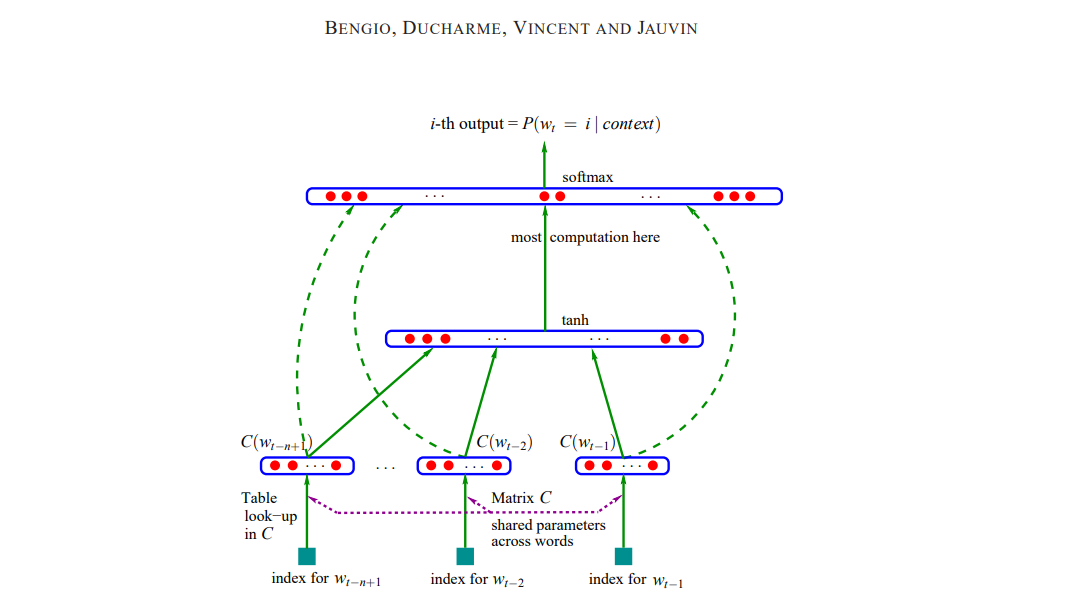

## Implementing the Look-up Table
- According to the Research Paper, they implemented a look-up table to map their 27K input vector space into a 30-dimensional vector space.  
- In my case, I will create a look-up table that transforms my 27-dimensional vector space into a 2-dimensional vector space.

In [7]:
C = torch.randn((27, 2))
C

tensor([[-2.3499e-01,  8.5738e-01],
        [ 1.3343e+00, -4.0770e-01],
        [ 8.3663e-02,  7.6766e-01],
        [ 1.1710e+00,  7.2743e-01],
        [-1.3280e-03,  1.9716e+00],
        [-7.7742e-01, -1.6726e+00],
        [-2.0245e-01, -2.2690e+00],
        [ 1.5740e+00,  5.8061e-01],
        [-1.0476e+00, -1.9183e+00],
        [-1.7960e-01, -1.3932e+00],
        [ 1.9743e+00,  1.7636e-01],
        [-1.5757e-01, -5.5392e-01],
        [ 8.0730e-02, -3.1931e-01],
        [-6.5435e-02, -3.9222e-02],
        [ 1.0303e-01,  1.0480e+00],
        [-4.2463e-01,  8.6602e-02],
        [ 1.9999e+00, -2.1914e-01],
        [ 1.1587e+00,  3.3300e-02],
        [ 1.3232e+00, -1.5930e-02],
        [ 1.1315e+00,  3.1938e-01],
        [ 8.4391e-02,  1.0065e+00],
        [-1.0426e-01, -1.0687e+00],
        [ 1.2047e-01,  7.2813e-01],
        [ 2.5333e-01, -5.9652e-01],
        [ 1.3380e+00, -6.9084e-01],
        [ 1.1932e+00,  1.6690e+00],
        [ 2.3318e+00,  6.0544e-01]])

In [8]:
C[5]

tensor([-0.7774, -1.6726])

In [9]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.7774, -1.6726])

In [10]:
emb = C[x]
emb.shape

torch.Size([228146, 3, 2])

In [11]:
w1 = torch.randn((6, 100))
b1 = torch.randn(100)
h = torch.tanh((emb.view(emb.shape[0], 6) @ w1) + b1)
h.shape

torch.Size([228146, 100])

In [12]:
w2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = (h @ w2) + b2
logits.shape

torch.Size([228146, 27])

In [13]:
counts = logits.exp()
prob = counts / counts.sum(dim = 1, keepdims = True)

In [14]:
loss = -prob[torch.arange(len(y)), y].log().mean().item()
loss

15.585741996765137

## Summary of MLP Language Model Implementation

The training set is a sequence of tokens  

$$
w_1, w_2, \dots, w_T
$$  

where each word  

$$
w_t \in V, \quad |V| = 27
$$  

The objective is to model the conditional probability distribution:

$$
\hat{P}(w_t \mid w_{t-1}, \dots, w_{t-n+1})
$$

such that the likelihood of the sequence is maximized.  

---

### Embedding Layer (Mapping \( C \))
- Each word is mapped to a real vector:  

$$
C(i) \in \mathbb{R}^m
$$  

- In this implementation, the embedding matrix  

$$
C \in \mathbb{R}^{|V| \times m}
$$  

maps the 27-dimensional vocabulary into a **2-dimensional vector space** (\( m = 2 \)).  
- Each word is represented as a point in a low-dimensional continuous space, capturing semantic similarity.  

---

### Neural Network Transformation (Mapping \( g \))

The conditional probability function is modeled by a **two-layer Multi-Layer Perceptron (MLP):**

1. **Layer 1 (Projection + Nonlinearity):**  

$$
h = \tanh(W_1 \cdot \text{vec}(C(w_{t-n+1}), \dots, C(w_{t-1})) + b_1)
$$  

where  

$$
W_1 \in \mathbb{R}^{mn \times d}, \quad b_1 \in \mathbb{R}^d, \quad d = 100
$$  

2. **Layer 2 (Output Projection):**  

$$
z = W_2 \cdot h + b_2
$$  

where  

$$
W_2 \in \mathbb{R}^{d \times |V|}, \quad b_2 \in \mathbb{R}^{|V|}
$$  

Softmax converts logits into probabilities:  

$$
\hat{P}(w_t = i \mid w_{t-1}, \dots, w_{t-n+1}) = \frac{e^{z_i}}{\sum_{j=1}^{|V|} e^{z_j}}
$$  

---

### Training Objective

The model is trained by minimizing the **negative log-likelihood (NLL):**

$$
\mathcal{L} = -\frac{1}{T} \sum_{t=1}^T \log \hat{P}(w_t \mid w_{t-1}, \dots, w_{t-n+1})
$$  

The exponential of the average NLL corresponds to the **perplexity**, a standard evaluation metric for language models.  

---

### Geometric Interpretation
- Each word is represented as a point in a 2D embedding space.  
- The MLP projects these embeddings into a higher-dimensional hidden space  

$$
\mathbb{R}^{100}
$$  

and then back to the vocabulary distribution  

$$
\mathbb{R}^{27}
$$  

- By using distributed representations, the model avoids the **curse of dimensionality** that plagues statistical bigram models.  
 

---

### Why It Works
Words with similar syntactic and semantic roles (e.g., *dog* and *cat*, or *is* and *was*) are mapped to nearby points in the embedding space, allowing the model to generalize better across contexts.

In [15]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 10), generator = g, requires_grad = True)
out_features = 200
n_classes = 27
emb = C[x_train]
lr = 0.1

# Layer-1
weight_1 = torch.randn(((emb.shape[1] * emb.shape[2]), out_features), generator = g, requires_grad = True)
bias_1 = torch.randn(out_features, generator = g, requires_grad = True)

# Layer-2
weight_2 = torch.randn((out_features, n_classes), requires_grad = True)
bias_2 = torch.randn(n_classes, requires_grad = True)

# Hidden Layer
hidden_layer_1_output = None

# Parameters counting
parameters = [C, weight_1, weight_2, bias_1, bias_2]
n_parameters = sum(p.nelement() for p in parameters)
print(f"Total Trainable Parameters with current settings = {n_parameters}")

Total Trainable Parameters with current settings = 11897


In [16]:
epochs = []
loss_i = []
for i in range(200000):
    # Mini-batch generation
    rand_idx = torch.randint(0, x_train.shape[0], (32,))

    # Forward pass
    # Layer-1:
    emb = C[x_train[rand_idx]]
    layer_1_output = (emb.view(-1, 30) @ weight_1) + bias_1
    hidden_layer_1_output = torch.tanh(layer_1_output)

    # Layer-2:
    layer_2_output = (hidden_layer_1_output @ weight_2) + bias_2
    logits = layer_2_output

    # Evaluating Loss
    loss = F.cross_entropy(logits, y_train[rand_idx])

    # if i % 500 == 0:
    #     print(f"Epoch-{i+100} Loss: {loss:.3f}")

    # Backward pass
    for p in parameters:
        p.grad = None

    # Updating the Model's 
    lr = 0.1 if i < 100000 else 0.01
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    
    epochs.append(i)
    loss_i.append(loss.item())

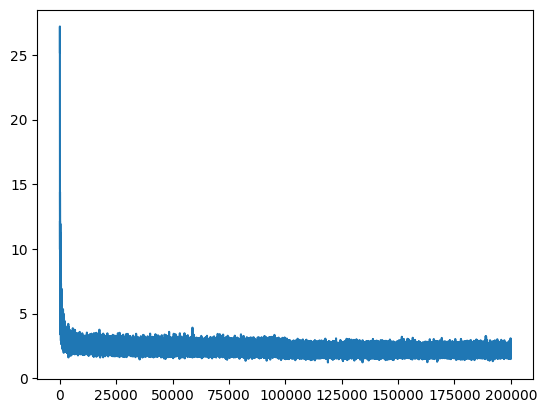

In [17]:
plt.plot(epochs, loss_i)

In [18]:
# Evaluate the loss on validation test
def eval_loss(split):
    if split == "train":
        x_data, y_data = x_train, y_train
    elif split == "test":
        x_data, y_data = x_test, y_test
    elif split == "val":
        x_data, y_data = x_val, y_val
    else:
        raise ValueError("split must be 'train', 'test', or 'val'")

    emb = C[x_data]
    hidden_layer_output = torch.tanh((emb.view(-1, 30) @ weight_1) + bias_1)
    logits = (hidden_layer_output @ weight_2) + bias_2
    loss_val = F.cross_entropy(logits, y_data)
    print(f"Loss on {split} split = {loss_val}")
    return loss_val

val_loss = eval_loss('val')
test_loss = eval_loss('test')
train_loss = eval_loss('train')

Loss on val split = 2.1706371307373047
Loss on test split = 2.171159029006958
Loss on train split = 2.129122018814087


## Visualizing the Feature vector in 2d space for input character

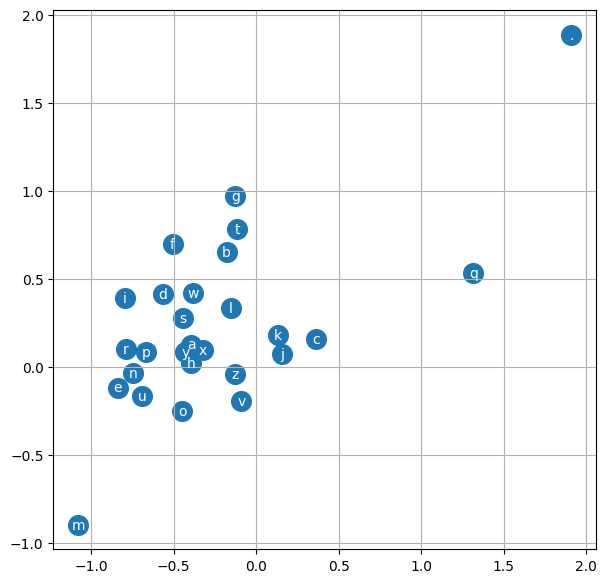

In [19]:
plt.figure(figsize=(7, 7))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid('minor')

## Predictions of our Model

In [ ]:
g = torch.Generator().manual_seed(42)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        hidden_layer_output = torch.tanh(emb.view(1, -1) @ weight_1 + bias_1)
        logits = hidden_layer_output @ weight_2 + bias_2
        probs = F.softmax(logits, dim = 1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    
    print(''.join(itos[i] for i in out))

yeesyah.
malin.
dleek.
ska.
gwayzeery.
kenchen.
emberlynn.
ize.
abke.
maris.


### Conclusion

In this project, I’ve implemented a two-layer MLP language model that learns to predict the next word in a sequence by leveraging **word embeddings**. I’ve mapped each word in the vocabulary to a low-dimensional continuous space, allowing the model to capture semantic and syntactic similarities. By passing these embeddings through a hidden layer with a nonlinear activation, I’ve enabled the model to learn complex patterns and dependencies between words.

Through this implementation, I’ve demonstrated how even a simple MLP can generalize across contexts, avoid the sparsity problems of traditional n-gram models, and provide a meaningful geometric interpretation of word relationships. Overall, this work shows the effectiveness of combining embeddings with neural networks for language modeling and lays the groundwork for exploring more advanced architectures in the future.